<a href="https://colab.research.google.com/github/lorrespz/Time-Series-Forecasting-Collection/blob/main/LSTM_for_stock_return_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM for stock return prediction

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data: Starbuck stock from 2013-2018

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX
...,...,...,...,...,...,...,...
1254,2018-02-01,56.280,56.420,55.890,56.000,14690146,SBUX
1255,2018-02-02,55.900,56.320,55.700,55.770,15358909,SBUX
1256,2018-02-05,55.530,56.260,54.570,54.690,16059955,SBUX
1257,2018-02-06,53.685,56.060,53.560,55.610,17415065,SBUX


Eventually, we would like to predict the **return** of the stock, and not its **price**, since it's much more feasible to work with the 'return' series instead of the price series, which sees wild fluctuations. The return is defined as:

$Return = \dfrac{Initial - Present}{Initial}$

In [4]:
# Create a column called 'PrevClose' in the dataframe by shifting the 'close' column by 1 value
df['PrevClose'] = df['close'].shift(1)

In [5]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [6]:
# Now create the 'return' column using the above formula: (x[t]-x[t-1])/x[t-1]
df['return'] = (df['close']-df['PrevClose']) /df['PrevClose']

In [7]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


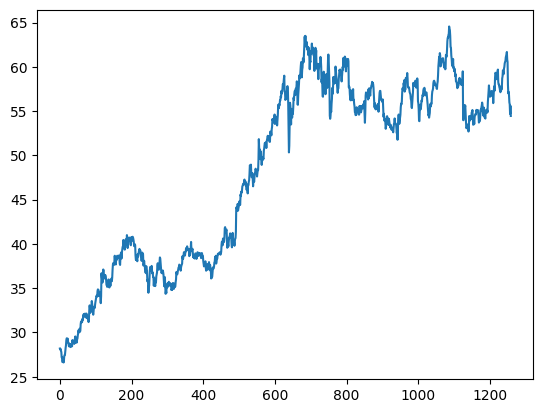

In [8]:
plt.plot(df['close'])

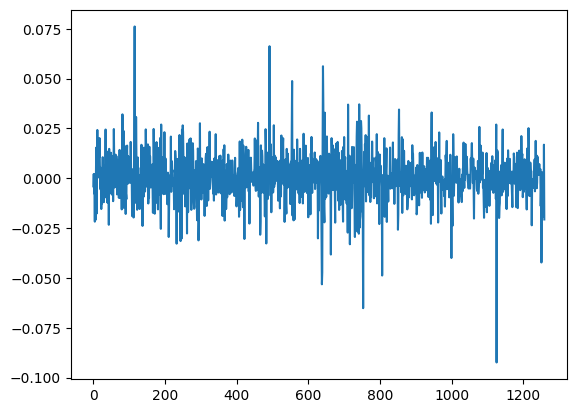

In [9]:
plt.plot(df['return'][1:])

Notice how much more stable the 'return' series is compared to the 'close' series.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define useful functions

## Create series data

In [11]:
#This function creates a dataset in which T past values are used to predict 1 future value
def make_series(series, T):
  X = []
  y = []
  for t in range(len(series) - T):
    X.append(series[t:t+T])
    y.append(series[t+T])

  #reshaping the arrays to have form NxTxD
  X = np.array(X).reshape(-1,T,1)
  y = np.array(y).reshape(-1,1)
  print(f'X shape: {X.shape}, y shape: {y.shape}')

  return X, y



## Define an autoregressive RNN model

In [12]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs, device):
    super(RNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(input_size = self.D,
                       hidden_size = self.M,
                       num_layers = self.L,
                       batch_first = True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    #initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    #get LSTM unit output:
    out, _ = self.rnn(X, (h0,c0))

    #we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])

    return out

## Define the training function

In [13]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs = 200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [14]:
def plot_losses(train_losses, test_losses):
  # Plot the train loss and test loss per iteration
  plt.plot(train_losses, label='train loss')
  plt.plot(test_losses, label='test loss')
  plt.legend()
  plt.show()

# Define one-step prediction & multi-step prediction

In [15]:
def one_step_forecast(Y):
  # One-step forecast using true targets
  validation_target = Y
  validation_predictions = []
  T = 10

  # index of first validation input
  i = 0

  X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

  while len(validation_predictions) < len(validation_target):
    input_ = X_on_device[i].reshape(1, T, 1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)


  plt.plot(validation_target, label='forecast target')
  plt.plot(validation_predictions, label='forecast prediction')
  plt.legend()

In [16]:
def multi_step_forecast(Y):
  # Multi-step forecast
  validation_target = Y[-N//2:]
  validation_predictions = []
  T = 10
  # last train input
  last_x = X_test[0].view(T)

  while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

  plt.plot(validation_target, label='forecast target')
  plt.plot(validation_predictions, label='forecast prediction')
  plt.legend()

# Predict stock price with the autoregressive LSTM model

Note that this is the WRONG thing to do, but for pedagogical purporse, let's go through this.

In [30]:
series = df['close'].values.reshape(-1,1)

In [31]:
#Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [32]:
X, y  = make_series(series, 10)

X shape: (1249, 10, 1), y shape: (1249, 1)


In [33]:
model = RNN(1, 5, 1, 1, device = device)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [34]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [35]:
# Make inputs and targets
N = len(X)
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(y[-N//2:].astype(np.float32))

In [36]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [37]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.4155, Test Loss: 2.2674
Epoch 10/200, Train Loss: 0.1341, Test Loss: 0.5495
Epoch 15/200, Train Loss: 0.0470, Test Loss: 0.4053
Epoch 20/200, Train Loss: 0.0085, Test Loss: 0.0691
Epoch 25/200, Train Loss: 0.0110, Test Loss: 0.0485
Epoch 30/200, Train Loss: 0.0095, Test Loss: 0.0395
Epoch 35/200, Train Loss: 0.0092, Test Loss: 0.0387
Epoch 40/200, Train Loss: 0.0078, Test Loss: 0.0457
Epoch 45/200, Train Loss: 0.0071, Test Loss: 0.0311
Epoch 50/200, Train Loss: 0.0064, Test Loss: 0.0386
Epoch 55/200, Train Loss: 0.0059, Test Loss: 0.0307
Epoch 60/200, Train Loss: 0.0055, Test Loss: 0.0389
Epoch 65/200, Train Loss: 0.0052, Test Loss: 0.0291
Epoch 70/200, Train Loss: 0.0051, Test Loss: 0.0297
Epoch 75/200, Train Loss: 0.0050, Test Loss: 0.0320
Epoch 80/200, Train Loss: 0.0049, Test Loss: 0.0296
Epoch 85/200, Train Loss: 0.0049, Test Loss: 0.0332
Epoch 90/200, Train Loss: 0.0049, Test Loss: 0.0303
Epoch 95/200, Train Loss: 0.0049, Test Loss: 0.0298
Epoch 100/200

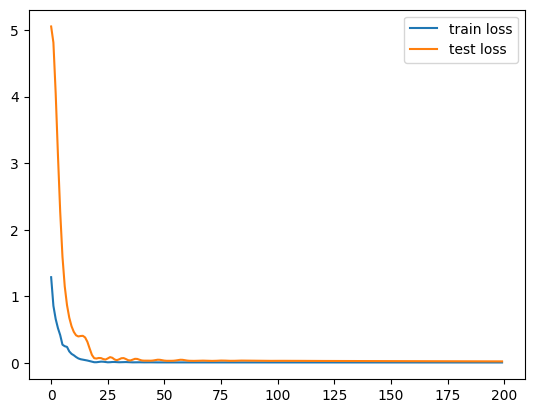

In [38]:
plot_losses(train_losses, test_losses)

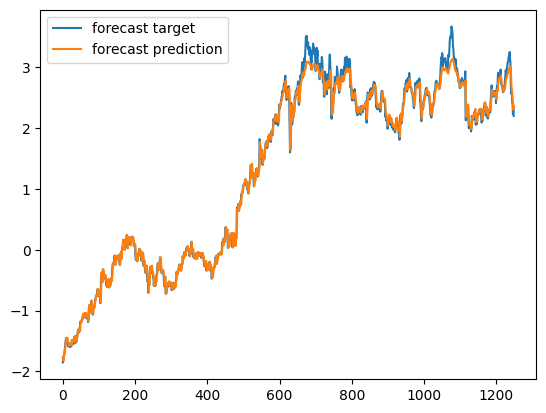

In [39]:
one_step_forecast(y)

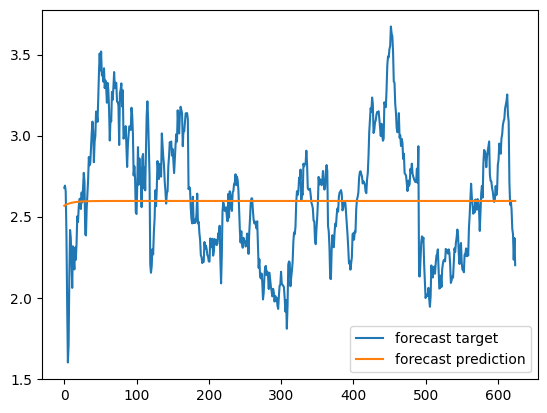

In [40]:
multi_step_forecast(y)

Notice that the model is not predicting anything, it just copies the previous value to the next.

# Predict stock return with the autoregressive LSTM model

In [17]:
series = df['return'].values[1:].reshape(-1,1)

In [18]:
series

array([[-0.00408018],
       [ 0.00213751],
       [-0.00764309],
       ...,
       [-0.01936525],
       [ 0.01682209],
       [-0.02067973]])

In [19]:
#Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [20]:
series

array([-0.43811722,  0.08061497, -0.73536414, ..., -1.71332483,
        1.30572463, -1.82299002])

In [21]:
X, y  = make_series(series, 10)

X shape: (1248, 10, 1), y shape: (1248, 1)


In [22]:
model = RNN(1, 5, 1, 1, device = device)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [24]:
# Make inputs and targets
N = len(X)
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(y[-N//2:].astype(np.float32))

In [25]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [26]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.9909, Test Loss: 1.1301
Epoch 10/200, Train Loss: 1.0095, Test Loss: 1.1282
Epoch 15/200, Train Loss: 0.9882, Test Loss: 1.1923
Epoch 20/200, Train Loss: 0.9809, Test Loss: 1.1441
Epoch 25/200, Train Loss: 0.9803, Test Loss: 1.1472
Epoch 30/200, Train Loss: 0.9759, Test Loss: 1.1795
Epoch 35/200, Train Loss: 0.9708, Test Loss: 1.1608
Epoch 40/200, Train Loss: 0.9674, Test Loss: 1.1816
Epoch 45/200, Train Loss: 0.9637, Test Loss: 1.1931
Epoch 50/200, Train Loss: 0.9585, Test Loss: 1.1949
Epoch 55/200, Train Loss: 0.9526, Test Loss: 1.2015
Epoch 60/200, Train Loss: 0.9441, Test Loss: 1.1930
Epoch 65/200, Train Loss: 0.9347, Test Loss: 1.1931
Epoch 70/200, Train Loss: 0.9240, Test Loss: 1.2074
Epoch 75/200, Train Loss: 0.9091, Test Loss: 1.2124
Epoch 80/200, Train Loss: 0.8874, Test Loss: 1.2226
Epoch 85/200, Train Loss: 0.8691, Test Loss: 1.2453
Epoch 90/200, Train Loss: 0.8529, Test Loss: 1.2781
Epoch 95/200, Train Loss: 0.8348, Test Loss: 1.3172
Epoch 100/200

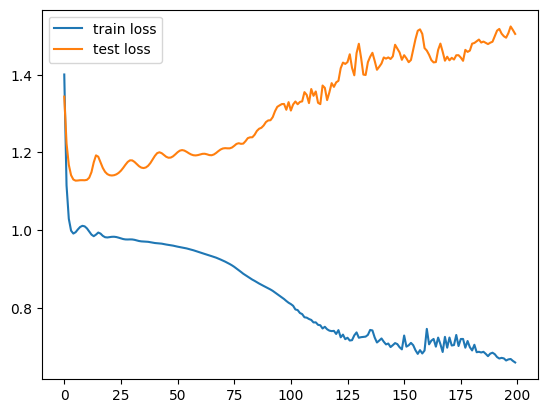

In [27]:
plot_losses(train_losses, test_losses)

The validation loss goes up during the training, so the model is probably fitting to the noise

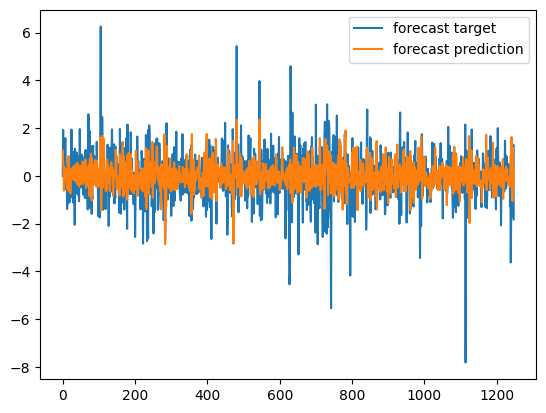

In [28]:
one_step_forecast(y)

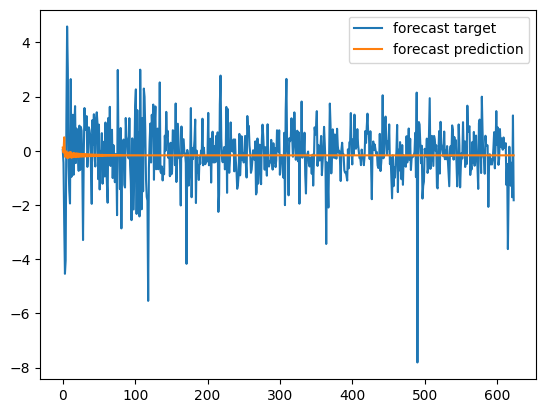

In [29]:
multi_step_forecast(y)